Authors: Jimena Gonzalez & Gillian Cartwright

In [1]:
script = False
cluster = False


In [2]:
# general
import numpy as np
from numpy.ma import masked_array
import pandas as pd
import random
import os
import gc

# images & plotting
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import make_lupton_rgb

# pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
import inspect

# albumentations transformations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# loading bar
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
plt.style.use('dark_background')
if(script):
    from tqdm import tqdm
else: 
    from tqdm.auto import tqdm
    import ipywidgets as widgets
    widgets.IntProgress()
        
if(cluster):
    from torch.serialization import add_safe_globals
        
from tqdm.auto import tqdm
import ipywidgets as widgets
widgets.IntProgress()

IntProgress(value=0)

In [3]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    Args:
        * seed {int}: number of the seed
    Returns: void
    """
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
# set seeds
seed_everything(9)

# set path name
if cluster:
    path = '' # OSG
else:
    path = '/Users/jimenagonzalez/research/DSPL/Hybrid_SL_Modeling/Segmentation/ML/data/' # local

npos = 20  # number of images TESTING
num_workers = 0  # number of available CPUs
num_epochs = 2  # number of epochs TESTING
num_classes = 4

# get data from fits file
hdu_list = fits.open(path + 'labeled_simulations.fits')
idx = random.sample(range(npos), npos)  # TESTING (using all test data available)
images = hdu_list[1].data[idx,:].astype(np.float32)
labels = hdu_list[4].data[idx,:].astype(np.float32)
data = pd.DataFrame(hdu_list[5].data[:][idx])
data = data.drop('TILENAME', axis=1)
hdu_list.close()

# check that data was loaded successfully
print(images.shape, labels.shape)

NUM_PIX = 45  # number of pixels per axis


(20, 3, 45, 45) (20, 4, 45, 45)


In [5]:
class ImageDataset(Dataset):
    """
    PyTorch dataset of Images, Data and Labels
    Args:
        * images {(N, channels, pix, pix) array}: images for dataset
        * data {pandas dataframe}: data for images
        * labels {(N, classes, pix, pix) array}: labels/masks for images
        * mode {str}: 'Train' or 'Test'
        * transform: composed albumentations augmentations to be applied
                     to training images
        * resize: composed albumentations augmentation to resize images
                  and masks to correct size (96, 96) & tensor
    Returns: Pytorch dataset
    """

    def __init__(self, images, data, labels, transform=None, resize=None):
        super().__init__()
        self.images = images
        self.data = data
        self.labels = labels
        self.transform = transform
        self.resize = resize

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]  # get image
        image = self.normalize(img)
        label = self.labels[idx]  # get label
        data_point = self.data.iloc[idx].to_dict()  # get data

        # transpose to appropriate dimensions
        image = image.transpose(1, 2, 0)  # (pix, pix, channels)
        label = label.transpose(1, 2, 0)  # (pix, pix, classes)

        # transform
        if self.transform is not None:
            image = image.astype(np.float32)
            transformed = self.transform(image=image, mask=label)
            image = transformed['image']
            label = transformed['mask']

        # resizing transformation
        resized = self.resize(image=image, mask=label)
        image = resized['image']
        label = resized['mask']
        
        # return item
        return {'image': image, 'label': label, 'img': img, 'data': data_point}

    def normalize(self, image):
        """
        Normalize image between 0 and 1 using min and max
        Args:
        * image: (3, pix, pix) numpy array
        Returns: normalized image in original size
        """
        normed = np.empty(image.shape)  # break
        MIN = np.min(image)
        MAX = np.max(image)
        for band in range(3):
            flat = image[band].flatten(order='C')
            for i in range(len(flat)):
                flat[i] = (flat[i]-MIN)/(MAX-MIN)

            normed[band] = np.reshape(flat, image[0].shape, order='C')

        return normed

In [6]:
def make_train_test_datasets(images, data, labels, test_size, transform=None, resize=None):
    """
    Make two datasets
    Args:
        * images {(N, channels, pix, pix) array}: all images
        * data {pandas dataframe}: data from fits file
        * labels {(N, classes, pix, pix) array}: all masks/labels
        * test_size {float}: the fraction of the images to use as the test dataset
        * transform: albumentations transformations to apply to training dataset
        * resize: albumentations transform to resize (h, w) from (45, 45) to (96, 96)
    Returns
        * train_dataset: An instance of the ImageDataset Class for training
        * test_dataset: An instance of the ImageDataset Class for testing
    """

    # Shuffle and split data
    train_images, test_images, train_data, test_data, train_labels, test_labels = train_test_split(
        images, data, labels, test_size=test_size, random_state=6)
    
    # Create PyTorch Datasets
    return (ImageDataset(train_images, train_data, train_labels, transform=augs, resize=resize_transform),
            ImageDataset(test_images, test_data, test_labels, transform=None, resize=resize_transform))

In [7]:
def show_training_set(train_dataset, idx):
    """
    Plot training dataset with transformations for visualization
    Args:
        * train_dataset: instance of ImageDataset for training
    Returns: void
    """
    sample = train_dataset[idx]
    orig, train, label = sample['img'], sample['image'], sample['label']

    # set up figure
    loc = plticker.MultipleLocator(base=3.75)
    fig, ax = plt.subplots(figsize=(15, 4), ncols=3)
    
    # original image
    orig_rgb = make_lupton_rgb(orig[2], orig[1], orig[0], Q=11., stretch=40.)
    ax[0].set_title('Original Image')
    ax[0].xaxis.set_ticklabels([])
    ax[0].yaxis.set_ticklabels([])
    ax[0].imshow(orig_rgb, aspect='equal')

    # transformed image
    new_rgb = make_lupton_rgb(train[2], train[1], train[0], stretch=0.4, Q=5)
    ax[1].set_title('Transformed Image')
    ax[1].xaxis.set_ticklabels([])
    ax[1].yaxis.set_ticklabels([])
    ax[1].imshow(new_rgb, aspect='equal')

    # training image (also transformed)
    lens = masked_array(label[:, :, 1], label[:, :, 1]!=1) # when lens is 1 show lens
    noise = masked_array(label[:, :, 2], label[:, :, 2]!=1)  # when noise is 1 show noise
    
    ax[2].set_title('Training Label')
    ax[2].imshow(label[:, :, 0], interpolation='nearest', cmap='magma')  # source
    ax[2].imshow(lens, interpolation='nearest', cmap='spring')  # lens
    ax[2].imshow(noise, interpolation='nearest', cmap='cool') # noise
    ax[2].axis('off')

    if not script:
        plt.show()
        plt.close()


In [8]:
augs = A.Compose([
           A.OneOf([A.ElasticTransform(alpha = NUM_PIX*0.03, sigma = NUM_PIX*0.3, alpha_affine =NUM_PIX*0.1),
                    A.GridDistortion(num_steps=5, distort_limit=0.3),
                    A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05)
    ], p=.25)
])


resize_transform = A.Compose([A.Resize(96, 96), ToTensorV2()])

reverse_resize = A.Compose([A.Resize(NUM_PIX, NUM_PIX)])

In [9]:
# split data into train and valid/test
train_dataset, other_dataset = make_train_test_datasets(images, data, labels, test_size=0.2,
                                                        transform=augs, resize=resize_transform)
# split valid/test dataset into validate and test
valid_dataset, test_dataset = make_train_test_datasets(other_dataset.images, other_dataset.data,
                                                       other_dataset.labels, test_size=0.5,
                                                       transform=None, resize=resize_transform)
# check datasets
print('Len train dataset: {}, len test dataset: {}'.format(len(train_dataset), len(test_dataset)))


Len train dataset: 16, len test dataset: 2


In [10]:


# set up dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=5,
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=5,
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1,
                                          num_workers=num_workers, shuffle=True)
torch.save(test_loader, 'test_loader.pth')



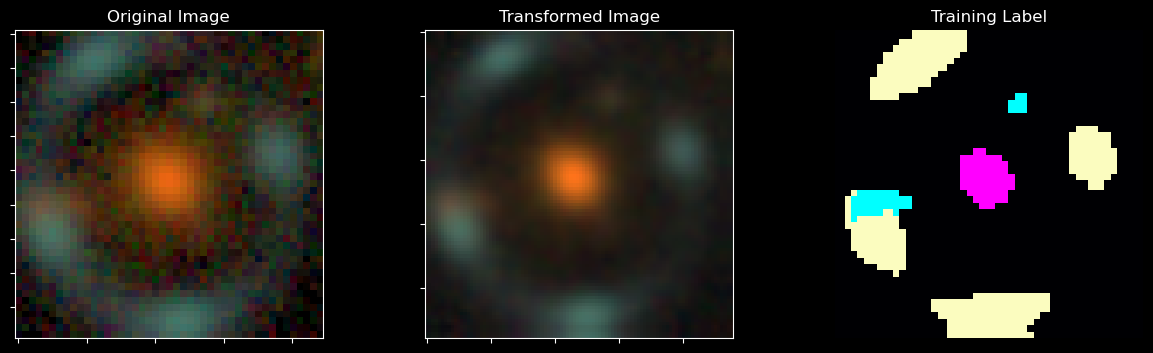

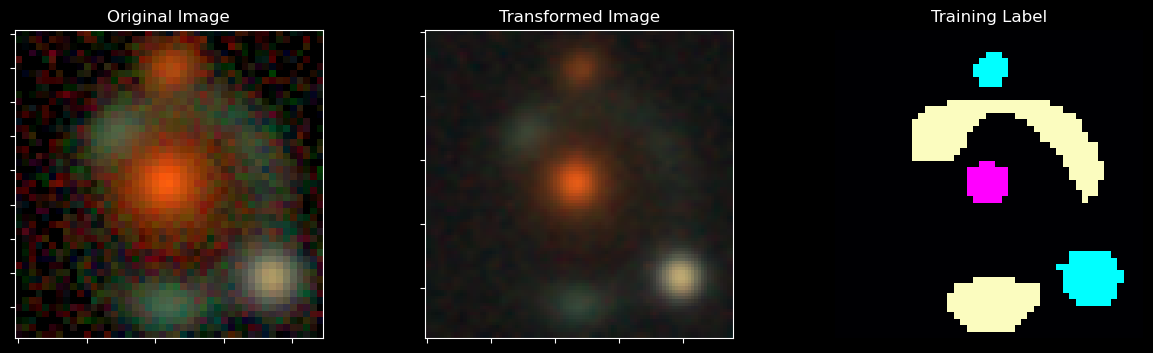

In [11]:
if script == False:
    for idx in range(2):
        show_training_set(train_dataset, idx)

In [12]:
#Implementing boundary loss
import torch.nn.functional as F
from scipy.ndimage import distance_transform_edt as distance

class BoundaryLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, logits, targets):
        # logits: (N, C, H, W)
        # targets: (N, H, W) class indices
        
        probs = torch.softmax(logits, dim=1)

        boundary_loss = 0.0
        num_classes = probs.shape[1]

        for c in range(num_classes):
            pc = probs[:, c]                     # (N, H, W)
            tc = (targets == c).float()          # binary mask

            # distance transform of ground truth
            dist_map = torch.from_numpy(distance(1 - tc.cpu().numpy())).to(logits.device)

            boundary_loss += (pc * dist_map).mean()

        return boundary_loss / num_classes
    
#Calculating weights for loss functions:
def calculate_weights():
    class_pixel_count = torch.zeros(num_classes)
    class_image_pixel_count = torch.zeros(num_classes)

    for sample in tqdm(train_loader):
        target_oh = sample["label"].permute(0, 3, 1, 2)  # (B,C,H,W)
        target = target_oh.argmax(dim=1)                 # (B,H,W)

        for c in range(num_classes):
            mask = (target == c)
            pixels = mask.sum().item()

            if pixels > 0:  # class present in image
                class_pixel_count[c] += pixels
                class_image_pixel_count[c] += mask.numel()  # total pixels in those images

    freq = class_pixel_count / class_image_pixel_count
    median_freq = torch.median(freq)

    class_weights = median_freq / freq
    class_weights = class_weights / class_weights.sum() * num_classes  # normalize (optional)
    return(class_weights)

In [13]:
class UNet(nn.Module):
    """
    U-Net model
    """
    def __init__(self, classes, pretrained=False): 
        super(UNet, self).__init__()

        if(not cluster):
            self.model = smp.Unet(encoder_name="resnet50", encoder_weights="imagenet",
                                  in_channels=3, classes=classes)
            torch.save(self.model.state_dict(), 'initial_model.pt')

        else:
            self.model = smp.Unet(encoder_name="resnet50", in_channels=3, classes=classes)
            self.model.load_state_dict(torch.load('initial_model.pt'))


    def forward(self, x):
        """
        compute predicted outputs by passing inputs to the model
        """
        x = self.model(x)
        return x


    def accuracy_and_perclass(self, output, target):
        """
        get pixel accuracy
        """
        output = output.argmax(dim=1)
        tp, fp, fn, tn = smp.metrics.get_stats(output, target, mode='multiclass', num_classes=num_classes) #
        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro") #Intersection over Union
        dice = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro")
        dice_perclass = smp.metrics.f1_score(tp, fp, fn, tn, reduction="none").mean(dim=0)
        
        return dice, dice_perclass


    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        """
        train the model
        """
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0
        epoch_accuracy_perclass = torch.zeros(num_classes, dtype=torch.float32)

        self.model.train()

        for i, sample in enumerate(tqdm(train_loader)):  # tqdm
            
            data = sample['image']
            #target = sample["label"].permute(0, 3, 1, 2).contiguous()
            target_oh = sample["label"].permute(0, 3, 1, 2).contiguous()  # (B,4,H,W)
            target = target_oh.argmax(dim=1)  # (B,H,W)  long class indices 0..3
            sample_img = sample['img']
            sample_data = sample['data']

            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass
            output = self.forward(data)

            # calculate the batch loss
            loss = criterion(output, target) #.long()

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # Calculate Accuracy
            accuracy, per_class_dice = self.accuracy_and_perclass(output, target)
            #print(epoch_accuracy_perclass.shape, per_class_dice.shape)
            
            # update training loss and accuracy
            epoch_loss += loss.item()
            epoch_accuracy += accuracy.item()
            epoch_accuracy_perclass += per_class_dice.detach().cpu()
            optimizer.step()

        return (epoch_loss / len(train_loader), epoch_accuracy / len(train_loader), 
                epoch_accuracy_perclass / len(train_loader))


    def validate_one_epoch(self, valid_loader, criterion, device):
        """
        validate the model
        """
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0
        valid_accuracy_perclass = torch.zeros(num_classes, dtype=torch.float32)

        self.model.eval()
        for i, sample in enumerate(tqdm(valid_loader)): # tqdm
            data = sample['image']
            #target = sample["label"].permute(0, 3, 1, 2).contiguous()
            target_oh = sample["label"].permute(0, 3, 1, 2).contiguous()  # (B,4,H,W)
            target = target_oh.argmax(dim=1)  # (B,H,W)  long class indices 0..3
            sample_img = sample['img']
            sample_data = sample['data']

            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)

                # calculate the batch loss
                loss = criterion(output, target) #.long()

                # Calculate Accuracy
                accuracy, per_class_dice = self.accuracy_and_perclass(output, target)

                # update average validation loss and accuracy
                valid_loss += loss.item()
                valid_accuracy += accuracy.item()
                valid_accuracy_perclass += per_class_dice.detach().cpu()

        return (valid_loss / len(valid_loader), valid_accuracy / len(valid_loader),
                valid_accuracy_perclass / len(valid_loader))
    

In [14]:
def plot_performance(model):
    """
    Plot loss and accuracy vs. epoch
    Args:
        * model: trained model
    """
    #loss_train = [x.item() for x in model.loss_train]
    #loss_valid = [x.item() for x in model.loss_valid]
    #train_acc = [x.item() for x in model.train_acc]
    #valid_acc = [x.item() for x in model.validation_acc]
    
    x = np.linspace(1, len(model.loss_train), len(model.loss_train))
    fig, ax = plt.subplots(figsize=(16, 7), ncols=2)

    ax[0].set_title('Losses')
    ax[0].set_xlabel('Epoch')
    ax[0].scatter(x, loss_train, color='skyblue', alpha=0.8, label='Training loss')
    ax[0].scatter(x, loss_valid, color='limegreen', alpha=0.8,  label='Validation loss')
    ax[0].legend()
    
    ax[1].set_title('Dice')
    ax[1].set_xlabel('Epoch')
    ax[1].scatter(x, train_acc, color='skyblue', alpha=0.8,  label='Training Accuracy')
    ax[1].scatter(x, valid_acc, color='limegreen', alpha=0.8,  label='Validation Accuracy. Max: {:.2f}'.format(
        model.validation_acc[-1].item()))
    ax[1].legend()
    
    if(script and cluster):
        plt.savefig('Performance.png', bbox_inches='tight')
    else: 
        plt.show(block=True)
        
        
def plot_complete_performance(perf_data, epoch_stop):
    """
    Plot loss and accuracy vs. epoch | For all the training, and shows where it stopped training (saved model)
    Args:
        * model: trained model
    """
    loss_train = perf_data['loss_train']
    loss_valid = perf_data['loss_valid']
    train_acc = perf_data['train_acc']
    valid_acc = perf_data['validation_acc']
    
    x = np.linspace(1, len(model.loss_train), len(model.loss_train))
    fig, ax = plt.subplots(figsize=(16, 7), ncols=2)

    ax[0].set_title('Losses')
    ax[0].set_xlabel('Epoch')
    ax[0].axvline(epoch_stop, color='white', linestyle='--', linewidth=1.5, label='Early stopping', alpha=0.9)
    ax[0].scatter(x, loss_train, color='skyblue', alpha=1., label='Training loss')
    ax[0].scatter(x, loss_valid, color='limegreen', alpha=1.,  label='Validation loss')
    ax[0].legend()
    
    ax[1].set_title('Dice')
    ax[1].set_xlabel('Epoch')
    ax[1].axvline(epoch_stop, color='white', linestyle='--', linewidth=1.5, label='Early stopping', alpha=0.8)
    ax[1].scatter(x, train_acc, color='skyblue', alpha=1.,  label='Training Accuracy')
    ax[1].scatter(x, valid_acc, color='limegreen', alpha=1.,  label='Validation Accuracy. Max: {:.2f}'.format(
        model.validation_acc[-1]))
    ax[1].legend()
    
    if(script and cluster):
        plt.savefig('Performance_complete.png', bbox_inches='tight')
    else: 
        plt.show(block=True)
        
        
def plot_accs_perclass(perf_data, epoch_stop):
    #'train_acc_class0'
    x = np.linspace(1, len(model.loss_train), len(model.loss_train))
    
    plt.figure(figsize=(12, 6))
    #plt.title('S=Source, D=Deflector, N=Noise, B=Background')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.plot(x, perf_data['train_acc_class0'], color='#00FFFF', linestyle='--', alpha=0.6, zorder=1)
    plt.plot(x, perf_data['valid_acc_class0'], color='#00FFFF', linestyle='--', alpha=0.6, zorder=1)
    plt.plot(x, perf_data['train_acc_class1'], color='#FFD700', linestyle='--', alpha=0.6, zorder=1)
    plt.plot(x, perf_data['valid_acc_class1'], color='#FFD700', linestyle='--', alpha=0.6, zorder=1)
    plt.plot(x, perf_data['train_acc_class2'], color='#FF69B4', linestyle='--', alpha=0.6, zorder=1)
    plt.plot(x, perf_data['valid_acc_class2'], color='#FF69B4', linestyle='--', alpha=0.6, zorder=1)
    plt.plot(x, perf_data['train_acc_class3'], color='#00FF00', linestyle='--', alpha=0.6, zorder=1)
    plt.plot(x, perf_data['valid_acc_class3'], color='#00FF00', linestyle='--', alpha=0.6, zorder=1)
    plt.scatter(x, perf_data['train_acc_class0'], color='#00FFFF', alpha=0.8, marker = "^", label='Train Source')
    plt.scatter(x, perf_data['valid_acc_class0'], color='#00FFFF', alpha=0.8, marker="P", label='Valid Source')
    plt.scatter(x, perf_data['train_acc_class1'], color='#FFD700', alpha=0.8, marker = "^", label='Train Deflector')
    plt.scatter(x, perf_data['valid_acc_class1'], color='#FFD700', alpha=0.8, marker="P", label='Valid Deflector')
    plt.scatter(x, perf_data['train_acc_class2'], color='#FF69B4', alpha=0.8, marker = "^", label='Train Noise')
    plt.scatter(x, perf_data['valid_acc_class2'], color='#FF69B4', alpha=0.8, marker="P", label='Valid Noise')
    plt.scatter(x, perf_data['train_acc_class3'], color='#00FF00', alpha=0.8, marker = "^", label='Train Sky')
    plt.scatter(x, perf_data['valid_acc_class3'], color='#00FF00', alpha=0.8, marker="P", label='Valid Sky')
    plt.axvline(epoch_stop, color='white', linestyle='--', linewidth=1.5, label='Early stopping', alpha=0.7)
    plt.legend()
    if(script and cluster):
        plt.savefig('Performance_perclass.png', bbox_inches='tight')
    else: 
        plt.show(block=True)

In [15]:
def fit_tpu(model, name_model, epochs, device, criterion, optimizer, train_loader, valid_loader=None):
    """
    Train the model (fit tensor processing units)
    Args:
        * model {torch.nn.Module}: U-Net model
        * name_model {str}: name to save model under
        * epochs {int}: num_epochs
        * device {torch.device}: cpu or gpu
        * criterion {}: Jaccard loss
        * optimizer {}: Adam optimizer
        * train_loader: dataloader for training dataset
        * valid_loader: dataloader for validation dataset
    Returns: void
    """
    best_val_acc = 0.0 # track of best accuracy

    # keeping track of losses as it happen
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    train_accs_perclass = []
    valid_accs_perclass = []
    epoch_stop = 0

    # train
    for epoch in range(1, epochs + 1):
        gc.collect()
        print(f"{'=' * 100}")
        print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc, train_acc_perclass = model.train_one_epoch(train_loader, criterion, optimizer, device)
        print(f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n")
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_accs_perclass.append(train_acc_perclass)
        gc.collect()

        # moves towards valid_loader
        print("start valid_loader")

        if valid_loader is not None:
            gc.collect()
            print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc, valid_acc_perclass = model.validate_one_epoch(valid_loader, criterion, device)
            print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            valid_accs_perclass.append(valid_acc_perclass)
            gc.collect()

            # saving best performing model
            if(valid_acc > best_val_acc):
                epoch_stop = epoch
                setattr(model, 'loss_train', train_losses)
                setattr(model, 'loss_valid', valid_losses)
                setattr(model, 'train_acc', train_accs)
                setattr(model, 'validation_acc', valid_accs)
                #torch.save(model, name_model)
                torch.save({"model_state": model.state_dict(), "epoch": epoch,"best_val_acc": float(best_val_acc),
                "loss_train": train_losses, "loss_valid": valid_losses, "train_acc": train_accs, 
                "valid_acc": valid_accs}, name_model)
                best_val_acc = valid_acc
            
            #Saving data & figure of performance data points for the whole training process
            if(epoch == epochs):
                train_losses_list = train_losses #AKDSMFAKMDFLKAMDSLFKMASLDKFMALKDMFKLAMSDFKLMASLDKMFLKADF
                valid_losses_list = valid_losses
                train_accs_list = train_accs
                valid_accs_list = valid_accs
                
                #Accuracies per class, for train and valid
                stacked = torch.stack(train_accs_perclass)
                train_accs_perclass_list = stacked.T.tolist()
                stacked = torch.stack(valid_accs_perclass)
                valid_accs_perclass_list = stacked.T.tolist()
                
                perf_data = pd.DataFrame()
                perf_data['loss_train'] =  train_losses_list
                perf_data['loss_valid'] =  valid_losses_list
                perf_data['train_acc'] =  train_accs_list
                perf_data['validation_acc'] =  valid_accs_list
                perf_data['train_acc_class0'] =  train_accs_perclass_list[0]
                perf_data['train_acc_class1'] =  train_accs_perclass_list[1]
                perf_data['train_acc_class2'] =  train_accs_perclass_list[2]
                perf_data['train_acc_class3'] =  train_accs_perclass_list[3]
                perf_data['valid_acc_class0'] =  valid_accs_perclass_list[0]
                perf_data['valid_acc_class1'] =  valid_accs_perclass_list[1]
                perf_data['valid_acc_class2'] =  valid_accs_perclass_list[2]
                perf_data['valid_acc_class3'] =  valid_accs_perclass_list[3]
                perf_data.to_csv('performance_data.csv', index = False)
                print('Epoch stopped: ', epoch_stop)
                plot_complete_performance(perf_data, epoch_stop)
                plot_accs_perclass(perf_data, epoch_stop)

In [16]:
if(cluster):
    add_safe_globals([UNet])
    
# create model
model = UNet(classes=num_classes, pretrained=True)
    
# check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)


# loss functions to test
ce = nn.CrossEntropyLoss()
#class_weights = calculate_weights()
#class_weights = torch.clamp(class_weights, max=5.0)
#class_weights = class_weights.to(device) 
#print('Class weights: ', class_weights)
#ce_weighted = nn.CrossEntropyLoss(weight=class_weights)
dice = smp.losses.DiceLoss(mode="multiclass", from_logits=True)
#focal = smp.losses.FocalLoss(mode="multiclass", gamma=2.0)
#boundary = BoundaryLoss()
#Lovasz = smp.losses.LovaszLoss(mode="multiclass", from_logits=True)

λ_ce, λ_dice  = 0.6, 0.4
def criterion(y_pred, y_true):
    loss = λ_ce*ce(y_pred, y_true) + λ_dice*dice(y_pred, y_true)
    return loss

# set learning and optimizer
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


cpu


EPOCH 1 - TRAINING...


  0%|          | 0/4 [00:00<?, ?it/s]


	[TRAIN] EPOCH 1 - LOSS: 1.1894241273403168, ACCURACY: 0.19487455487251282

start valid_loader
EPOCH 1 - VALIDATING...


  0%|          | 0/1 [00:00<?, ?it/s]

	[VALID] LOSS: 1.2580664157867432, ACCURACY: 0.034930333495140076

EPOCH 2 - TRAINING...


  0%|          | 0/4 [00:00<?, ?it/s]


	[TRAIN] EPOCH 2 - LOSS: 1.082313060760498, ACCURACY: 0.25826841592788696

start valid_loader
EPOCH 2 - VALIDATING...


  0%|          | 0/1 [00:00<?, ?it/s]

	[VALID] LOSS: 1.2343451976776123, ACCURACY: 0.05208437144756317

Epoch stopped:  2


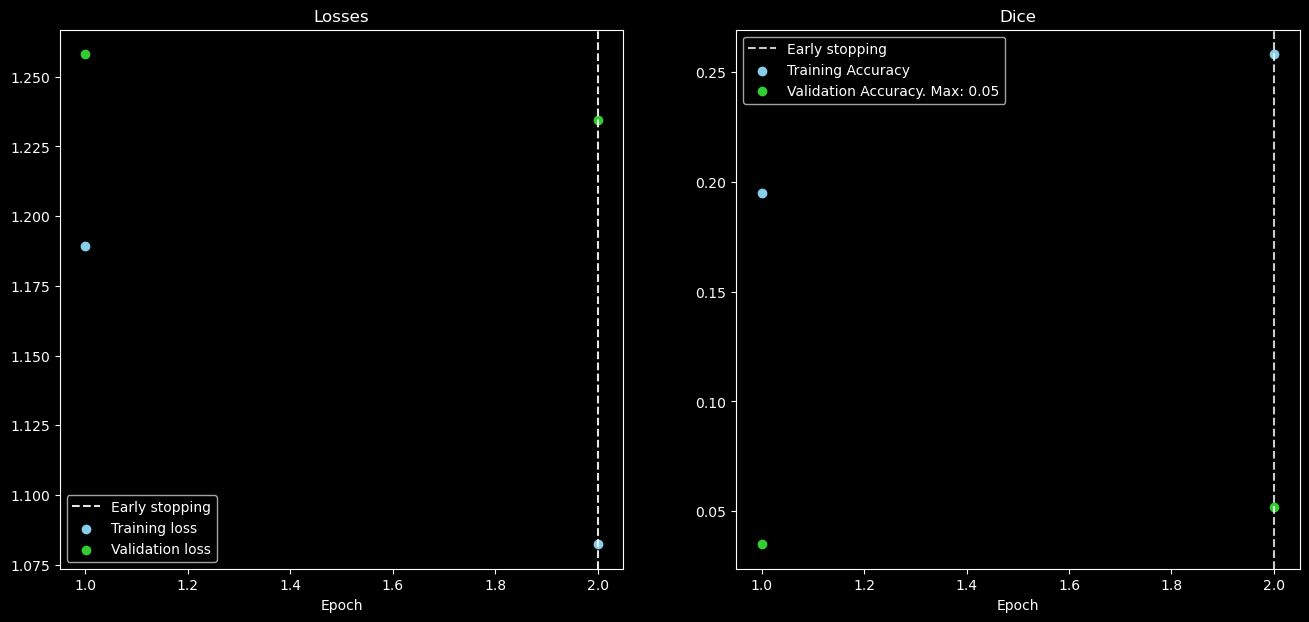

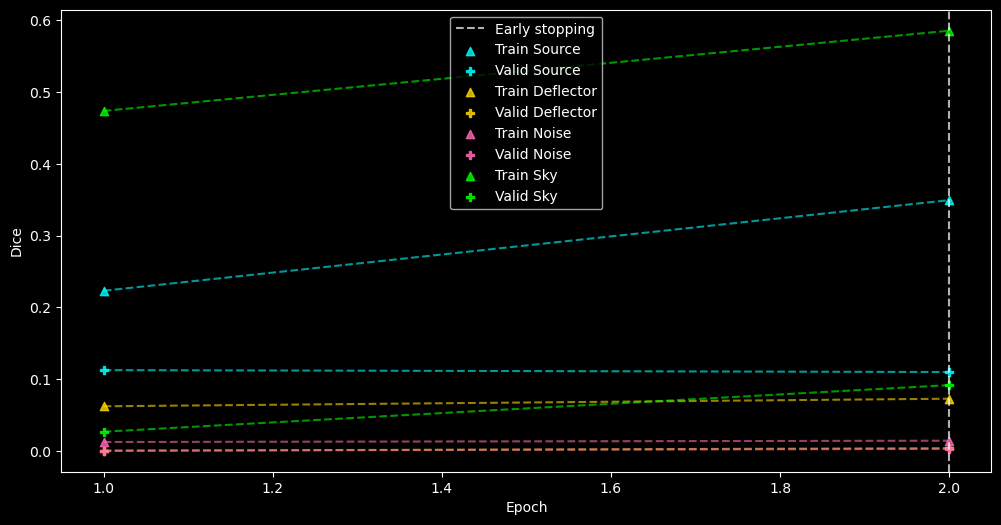

Maximum memory usage: 967.79296875


In [17]:
name_model = 'model_tmp.pt'
if not cluster:
    from memory_profiler import memory_usage
    mem_usage = memory_usage((fit_tpu, (model, name_model, num_epochs,
                                        device, criterion, optimizer, 
                                        train_loader, valid_loader)))
    print(f'Maximum memory usage: {max(mem_usage)}')

else:
    fit_tpu(model, name_model, num_epochs, device, criterion, optimizer, train_loader, 
            valid_loader)



In [18]:
def make_graphs(image, label, pred_label):
    loc = plticker.MultipleLocator(base=3.75)
    fig, ax = plt.subplots(figsize=(15, 4), ncols=3)

    rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
    ax[0].set_title('Original Image')
    ax[0].xaxis.set_ticklabels([])
    ax[0].yaxis.set_ticklabels([])
    ax[0].imshow(rgb, aspect='equal')

      # training image (also transformed)
    lens = masked_array(label[:, :, 1], label[:, :, 1]!=1) # when lens is 1 show lens
    noise = masked_array(label[:, :, 2], label[:, :, 2]!=1)  # when noise is 1 show noise
    
    ax[1].set_title('True Label')
    ax[1].imshow(label[:, :, 0], interpolation='nearest', cmap='magma')  # source
    ax[1].imshow(lens, alpha=0.5, interpolation='bilinear', cmap='spring')  # lens
    ax[1].imshow(noise, alpha=0.5, interpolation='bilinear', cmap='cool') # noise
    ax[1].axis('off')
    
    ax[2].set_title('Predicted Label')
    ax[2].imshow(pred_label[0, :, :], interpolation='nearest', cmap='magma')  # source
    ax[2].imshow(pred_label[1, :, :], alpha=0.5, interpolation='bilinear', cmap='spring')  # lens
    ax[2].imshow(pred_label[2, :, :], alpha=0.5, interpolation='bilinear', cmap='cool') # noise
    ax[2].axis('off')

    if script == False:
        plt.show()
        plt.close()

In [19]:
def testing_analysis(accu_lim, test_loader, num):
    model.double()
    segmented = np.zeros((1, 4, NUM_PIX, NUM_PIX))
    originals = np.zeros((1, 3, NUM_PIX, NUM_PIX))
    df = data.head(1)

    for i_batch, sample in enumerate(test_loader):
        if(i_batch == num): break
        sample_image, sample_label, sample_img, sample_data = sample['image'], sample['label'], sample['img'], sample['data']
        if device.type == "cuda":
            sample_image, sample_label = sample_image.cuda(), sample_label.cuda()

        output = model(sample_image)
        output = torch.softmax(output, dim=1)
        #output = output[0].detach().numpy()
        output = output[0].detach().cpu().numpy()
        
        # reverse resize transformation
        output = np.transpose(output, (1, 2, 0))  # shape must be (pix, pix, 3)     
        resized = reverse_resize(image=output)
        output = resized['image']
        output = np.transpose(output, (2, 0, 1))  # turn back into (3, pix, pix)

        original_img = sample_img[0].detach().numpy()

        segmented = np.append(segmented, [output], axis=0)
        originals = np.append(originals, [original_img], axis=0)
        df = pd.concat([df, pd.DataFrame.from_dict(sample_data)], ignore_index=True)

        if script == False:
            make_graphs(sample_img[0], sample_label[0], output)

    segmented = np.delete(segmented, 0, axis=0)
    originals = np.delete(originals, 0, axis=0)
    df = df.drop(0, axis=0)
    return originals, segmented, df



In [20]:
def write_fit_file(name, images, labels, data):
    """
    writes fits file with simulation data, simulation images, and mask images
    """
#     print(data[data.isna().any(axis=1)])
    my_types = {'Y6_COADD_OBJECT_ID': int, 'HPIX_16384': int, 'HPIX_4096': int,
       'DNF_ZMEAN_SOF': float, 'RA': float, 'DEC': float, 'FLUX_RADIUS_G': float, 'FLUX_RADIUS_R': float,
       'FLUX_RADIUS_I': float, 'FLUX_RADIUS_Z': float, 'KRON_RADIUS': float, 'GAP_FLUX_G': float,
       'MOF_BDF_FLUX_G': float, 'MOF_PSF_FLUX_G': float, 'SOF_BDF_FLUX_G': float, 'SOF_PSF_FLUX_G': float,
       'MAG_AUTO_G': float, 'MAG_APER_4_G': float, 'MAG_APER_8_G': float, 'SOF_BDF_G_1': float,
       'Y3_COADD_OBJECT_ID': int, 'REFMAG': float, 'REFMAG_ERR': float, 'LUM': float, 'ZREDMAGIC': float,
       'ZREDMAGIC_E': float, 'CHISQ': float, 'Z_LENS': float, 'MAG_G': float, 'MAG_R': float, 'MAG_I': float,
       'MAG_Z': float, 'MAG_ERR_G': float, 'MAG_ERR_R': float, 'MAG_ERR_I': float, 'MAG_ERR_Z': float,
       'ZG': float, 'ZR': float, 'ZI': float, 'ZZ': float, 'SOF_BDF_G_2': float, 'IMAFLAGS_ISO_G': int,
       'IMAFLAGS_ISO_R': int, 'IMAFLAGS_ISO_I': int, 'IMAFLAGS_ISO_Z': int, 'EXT_COADD': int,
       'FWHM_WMEAN_G': float, 'FWHM_WMEAN_R': float, 'FWHM_WMEAN_I': float, 'FWHM_WMEAN_Z': float,
       'SKYBRITE_WMEAN_G': float, 'SKYBRITE_WMEAN_R': float, 'SKYBRITE_WMEAN_I': float,
       'SKYBRITE_WMEAN_Z': float, 'Z1': float, 'LENSED_MAG': float, 'mag_1': float, 'ISOLATION': float,
       'EINSTEIN_RADIUS': float, 'MAGNIFICATION': float, 'POSITION1': float}
    data = data.astype(my_types)
    
    primary = fits.PrimaryHDU()
    image1 = fits.ImageHDU(images, name="IMAGE")  # original images
    image2 = fits.ImageHDU(labels, name="IMAGE")  # segmentation maps
    table_data = Table.from_pandas(data)
    table = fits.BinTableHDU(data = table_data)
    hdu_list = fits.HDUList([primary, image1, image2, table])
    hdu_list.writeto(name + '.fits', overwrite=True)   
    hdu_list.close()

## Testing

In [21]:
load_kwargs = dict()
if "weights_only" in inspect.signature(torch.load).parameters:
    load_kwargs["weights_only"] = False  # only on torch >= 2.6
    
#model = torch.load("model_tmp.pt", map_location=device, **load_kwargs)
ckpt = torch.load("model_tmp.pt", map_location=device, **load_kwargs)
model = UNet(classes=num_classes, pretrained=True).to(device)
model.load_state_dict(ckpt["model_state"])

#print('Maximum validation dice score: {:.2f}'.format(model.validation_acc[-1].item()))
test_loader = torch.load('test_loader.pth', **load_kwargs)

In [22]:
#plot_performance(model)


/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


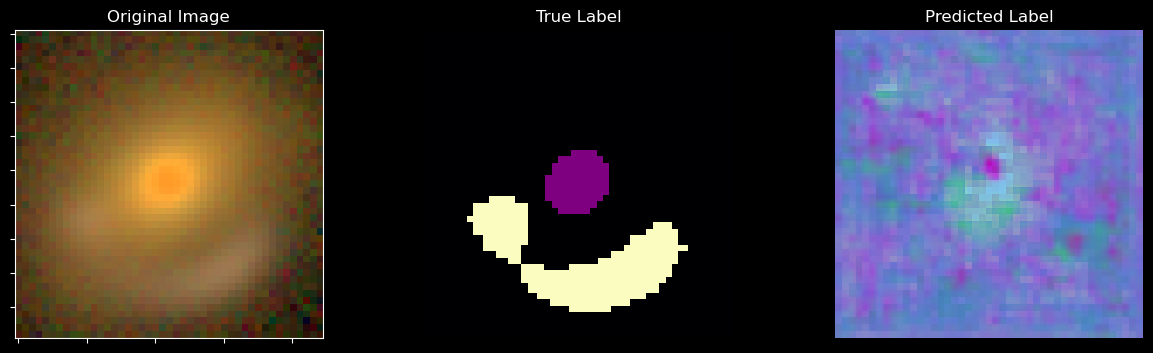

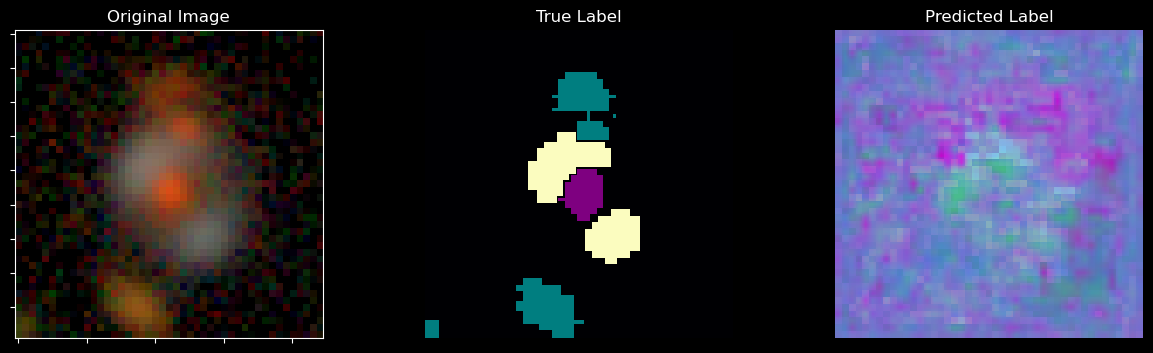

In [23]:
original_img, segmented, df = testing_analysis(0.5, test_loader, 20)
write_fit_file('segmented', original_img, segmented, df)
if(not cluster):
    plt.close('all')
